# Peaches vs Nectarines


Using computer vision to decipher between images of peaches and necatrines 

## Getting Data via goolge images

Scroll through google image search whichever items are loaded will be downloaded:

Command + Opt + J in console:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Directory and Url server files

In [1]:
from fastai import *
from fastai.vision import *

In [2]:
folder = 'peaches'
file = 'urls_peaches.txt'

In [3]:
folder = 'nectarines'
file = 'urls_nectarines.txt'

In [4]:
path = Path('data/fruit')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

## Download images

In [5]:
classes = ['nectarines','peaches']

In [6]:
download_images(path/file, dest, max_pics=250)

Error https://www.organicfacts.net/wp-content/uploads/2013/08/nectarines.jpg 'content-length'
Error https://www.starkbros.com/images/dynamic/2884-960x960.jpg 'content-length'
Error https://askthegreengenie.com/wp-content/uploads/2013/03/photodune-3892710-nectarine-xs.jpg 'content-length'
Error https://www.starkbros.com/images/dynamic/2883.jpg 'content-length'
Error https://imagesvc.timeincapp.com/v3/mm/image?url=https%3A%2F%2Fcdn-image.myrecipes.com%2Fsites%2Fdefault%2Ffiles%2Fstyles%2Fmedium_2x%2Fpublic%2Ffield%2Fimage%2Fpeach-nectarine-storage-hero-getty.jpg%3Fitok%3DyltJibiZ&w=1000&q=70 'content-length'
Error https://www.precisionnutrition.com/wp-content/uploads/2017/08/Nectarine-photo-683x1024.jpg 'content-length'
Error http://www.themeaningofpie.com/wp-content/uploads/2010/09/grilled_nectarines_lead1up.jpg 'content-length'
Error https://imagesvc.timeincapp.com/v3/mm/image?url=https%3A%2F%2Fcdn-image.myrecipes.com%2Fsites%2Fdefault%2Ffiles%2Fstyles%2Fmedium_2x%2Fpublic%2Fimage%2Fre

Removing images that aren't opening:

In [8]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

nectarines


/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


cannot identify image file '/home/ubuntu/course-v3/nbs/dl1/data/fruit/nectarines/00000235.jpg'
cannot identify image file '/home/ubuntu/course-v3/nbs/dl1/data/fruit/nectarines/00000216.jpg'


/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


cannot identify image file '/home/ubuntu/course-v3/nbs/dl1/data/fruit/nectarines/00000001.jpg'
cannot identify image file '/home/ubuntu/course-v3/nbs/dl1/data/fruit/nectarines/00000173.jpg'


/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


cannot identify image file '/home/ubuntu/course-v3/nbs/dl1/data/fruit/nectarines/00000150.jpg'
peaches


/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


## Review data

In [9]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [10]:
data.classes

['nectarines', 'peaches']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


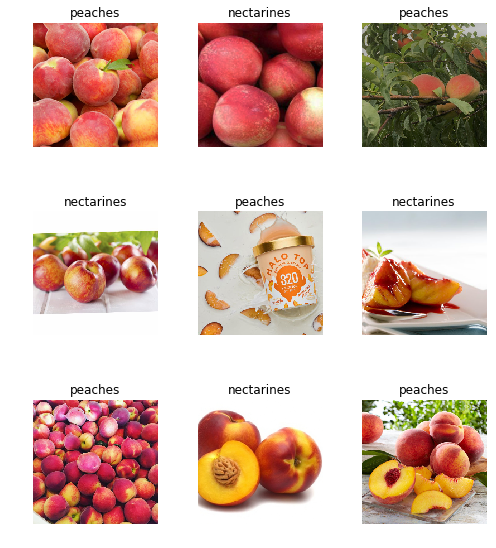

In [11]:
data.show_batch(rows=3, figsize=(7,8))

In [12]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['nectarines', 'peaches'], 2, 337, 99)

## Train model

In [13]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [14]:
learn.fit_one_cycle(4)

Total time: 00:52
epoch  train_loss  valid_loss  error_rate
1      0.854257    0.653029    0.323232    (00:15)
2      0.678637    0.569571    0.313131    (00:12)
3      0.585041    0.631403    0.282828    (00:12)
4      0.500052    0.644532    0.292929    (00:12)



In [15]:
learn.save('stage-1')

In [16]:
learn.unfreeze()

In [17]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


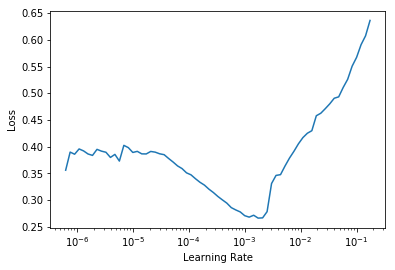

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

Total time: 00:26
epoch  train_loss  valid_loss  error_rate
1      0.342944    0.728276    0.272727    (00:13)
2      0.260363    0.788708    0.282828    (00:13)



In [20]:
learn.save('stage-2')

## Interpretation

In [21]:
learn.load('stage-2')

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

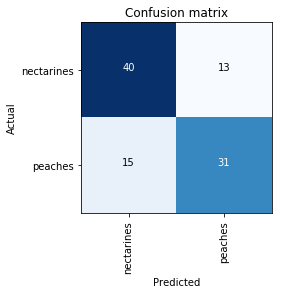

In [23]:
interp.plot_confusion_matrix()

## Review Model for Adjustments

In [24]:
from fastai.widgets import *

losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [25]:
fd = FileDeleter(file_paths=top_loss_paths)

Button(button_style='primary', description='Confirm', style=ButtonStyle())

## Model in production

In [26]:
data.classes

['nectarines', 'peaches']

In [27]:
# fastai.defaults.device = torch.device('cpu')

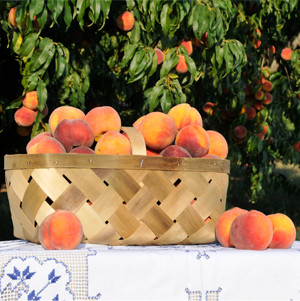

In [28]:
img = open_image(path/'peaches'/'00000237.jpg')
img

In [29]:
classes = ['nectarines', 'peaches']
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet34)
learn.load('stage-2')

In [30]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'peaches'

### Learning rate (LR) too high

In [140]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [141]:
learn.fit_one_cycle(1, max_lr=0.5)

Total time: 00:11
epoch  train_loss  valid_loss  error_rate      
1      25.007277   398748608.000000  0.536083    (00:11)



### Learning rate (LR) too low

In [142]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [143]:
learn.fit_one_cycle(5, max_lr=1e-5)

Total time: 00:59
epoch  train_loss  valid_loss  error_rate
1      0.853320    0.787124    0.463918    (00:12)
2      0.861509    0.721337    0.474227    (00:11)
3      0.857011    0.705977    0.463918    (00:11)
4      0.847042    0.705659    0.453608    (00:12)
5      0.844929    0.715907    0.453608    (00:11)



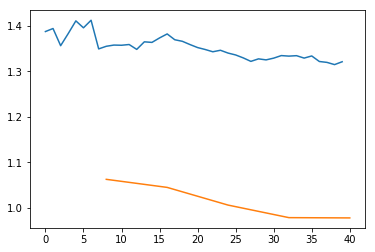

In [ ]:
learn.recorder.plot_losses()

### Too few epochs

In [144]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [145]:
learn.fit_one_cycle(1)

Total time: 00:11
epoch  train_loss  valid_loss  error_rate
1      0.842745    0.655799    0.350515    (00:11)



### Too many epochs

In [146]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [147]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 43739825.70it/s]


In [148]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

Total time: 07:16
epoch  train_loss  valid_loss  error_rate
1      0.824411    0.682127    0.461538    (00:23)
2      0.816204    0.685235    0.451282    (00:10)
3      0.779068    0.687143    0.474359    (00:10)
4      0.768457    0.684780    0.448718    (00:10)
5      0.740375    0.679192    0.435897    (00:10)
6      0.704076    0.674760    0.420513    (00:10)
7      0.646401    0.669622    0.405128    (00:09)
8      0.607782    0.666932    0.394872    (00:11)
9      0.562159    0.662469    0.376923    (00:11)
10     0.521301    0.663979    0.369231    (00:09)
11     0.485631    0.670472    0.361538    (00:11)
12     0.449749    0.667585    0.358974    (00:10)
13     0.419886    0.679017    0.358974    (00:11)
14     0.387806    0.686112    0.356410    (00:10)
15     0.360901    0.692605    0.361538    (00:10)
16     0.335216    0.692902    0.356410    (00:11)
17     0.312008    0.698187    0.371795    (00:10)
18     0.291615    0.705635    0.371795    (00:10)
19     0.273015    0.7